# QB Sentiment Analysis

Data was collected to analyze fan opinions of the top three quarterbacks in the 2024 draft class.

Data sources were:
* Team level - Quarterback press conference
* National level - Pat Mcafee (ESPN) segment
* Enthusiast level - Film breakdown video (Alex Rollins)

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
# reading in comments
dataframes = []

for csvfile in os.listdir('data'):
    # extract qb name and media type from filename
    qb, media = csvfile.replace('.csv', '').split('_')

    # read file into pandas dataframe
    df = pd.read_csv(f'data/{csvfile}', header=None)
    # add name for column containing text data
    df.rename(columns={0: 'text'}, inplace=True)
    # remove extra column, contains only NaN
    df.drop(columns=1, inplace=True)

    # add columns for qb and media type
    df['qb'] = qb
    df['media'] = media
    dataframes.append(df)

# create new dataframe from list of individuals
data = pd.concat(dataframes).drop_duplicates() 
# dropping duplicates because some comments will be read twice,
# once when finding 100 newest comments, and once when finding 100 most relevant comments

data.head()


,text,qb,media
0,Something about Adam Schefter is very unlikeab...,jayden,national
1,Adam doesn't tip while Ian tips 25 percent,jayden,national
2,Fr Mr editor smhhh,jayden,national
3,You mean the guy that looks like he starred in...,jayden,national
4,"Yes! ESPN sucks (not all , but most) Keep Da...",jayden,national


In [4]:
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
names = ['caleb', 'williams', 'jayden', 'daniels', 'drake', 'maye']

def preprocess_text(text):
    # tokenize
    # ignore punctuation for now
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())

    # remove stopwords or uninteresting words (names)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english') and token not in names]

    # lemmatize
    # lemmatizer = WordNetLemmatizer()
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(filtered_tokens)

In [6]:
# creating bag of words dictionary

bag = {'caleb': {},
       'jayden': {},
       'drake': {}}

# vectorized preprocessing function
preprocess_text_v = np.vectorize(preprocess_text)

In [7]:
grouped = data.groupby('qb')['text'].apply(preprocess_text_v)

In [8]:
# populating the bag of words
for qb, comments in grouped.items():
    # taking the quarterback name and array of comments from grouped df

    for comment in comments:
        # iterating over each comment in the array

        for word in comment.split(' '):
            # iterating over each word in the comment

            # if the word has already been talied for this quarterback, add 1 to the counter
            if word in bag[qb].keys():
                bag[qb][word] += 1
                
                # otherwise, initialize the counter as 1
            else:
                bag[qb][word] = 1

In [68]:
# create dataframe out of bag of words dictionary
bag_df = pd.DataFrame(bag)
bag_df.fillna(0, inplace=True)
bag_df.head()

,caleb,jayden,drake
cowherd,28.0,0.0,0.0
called,8.0,4.0,3.0
3pm,1.0,0.0,0.0
chicago,40.0,3.0,6.0
radio,1.0,0.0,1.0


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_theme(style='whitegrid')

In [11]:
qb_colors = {
    'jayden': '#5A1414', # commanders maroon
    'caleb': '#C83803', # bears orange
    'drake': '#002244' # patriots blue
}

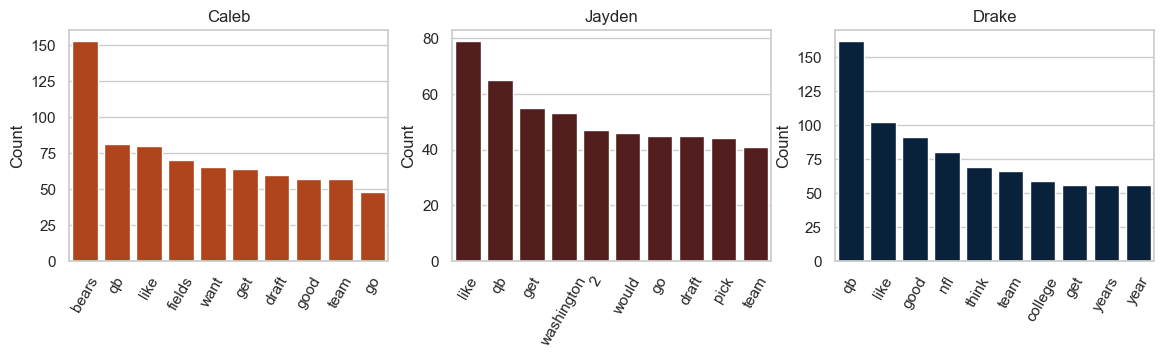

In [12]:
# most common words by quarterbacks
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))

for i, qb in enumerate(bag_df.columns):
    # get list of top ten most common words for each qb
    top_10 = bag_df[qb].sort_values(ascending=False).head(10).reset_index().rename(columns={'index': 'word', qb: 'count'})

    # plot barplot of top ten words
    sns.barplot(
        data = top_10,
        x = 'word',
        y = 'count',
        color = qb_colors[qb], # team colors
        ax = axes[i]
    )
    axes[i].set_title(qb.capitalize())
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=60) # rotate xticks


In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)

    return scores['compound']

In [14]:
# column for pre-processed comment
data['processed'] = preprocess_text_v(data['text'])
# calculate sentiment
data['sentiment'] = data['processed'].apply(get_sentiment)
# find word length for each comment
data['comment_length'] = data['text'].str.count(' ')

In [15]:
# average sentiment score by quarterback
data.groupby('qb')['sentiment'].mean()

qb
caleb     0.201069
drake     0.245778
jayden    0.159582
Name: sentiment, dtype: float64

In [16]:
# average sentiment score by media type
data.groupby('media')['sentiment'].mean()

media
film        0.260392
national    0.152876
team        0.214403
Name: sentiment, dtype: float64

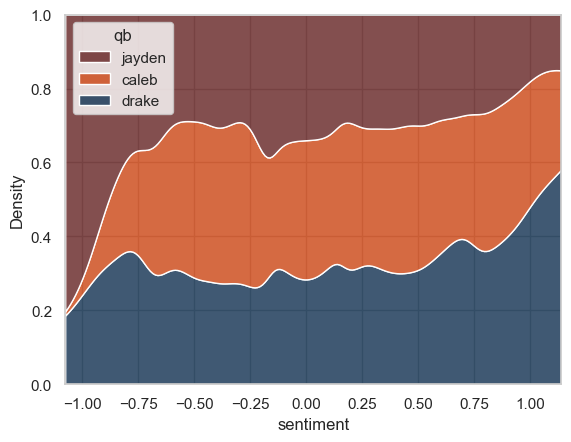

In [232]:
# distribition of sentiments by quarterback
sns.kdeplot(
    data = data,
    x = 'sentiment',
    hue = 'qb',
    palette=qb_colors.values(), 
    bw_adjust=.5,
    multiple='fill'
);

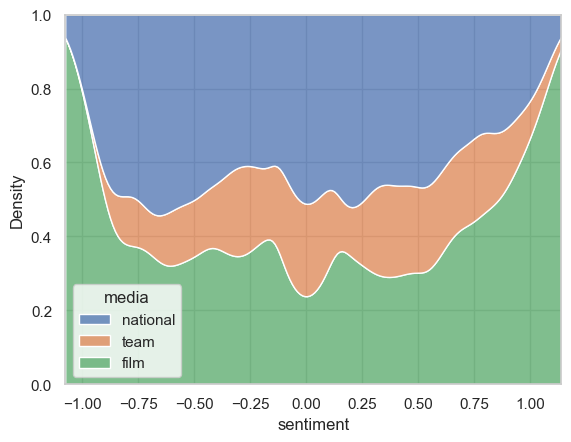

In [231]:
# distribution of sentiments by media type
sns.kdeplot(
    data = data,
    x = 'sentiment',
    hue = 'media',
    bw_adjust=.5, 
    multiple='fill'
);

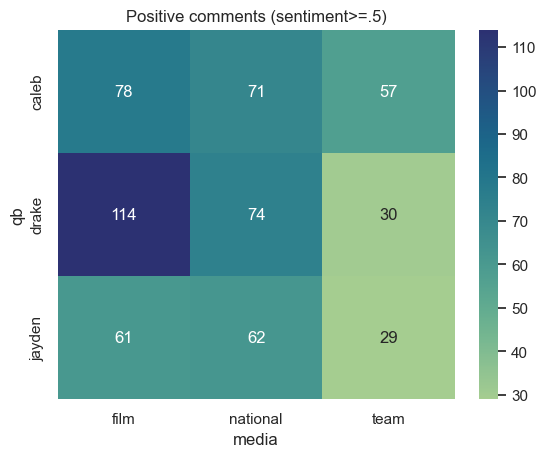

In [255]:
# positive comments tileplot
data['positive'] = data['sentiment'] >= .5
data['negative'] = data['sentiment'] <= -.5

positives = pd.pivot_table(data, index='qb', columns='media', values='positive', aggfunc='sum')

sns.heatmap(
    positives,
    annot=True,
    fmt='.0f',
    cmap='crest'
)
plt.title('Positive comments (sentiment>=.5)');

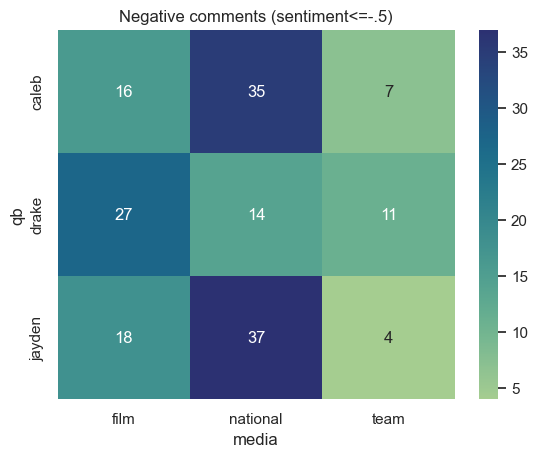

In [256]:
# negative comments tileplot
negatives = pd.pivot_table(data, index='qb', columns='media', values='negative', aggfunc='sum')

sns.heatmap(
    negatives,
    annot=True,
    fmt='.0f',
    cmap='crest'
)
plt.title('Negative comments (sentiment<=-.5)');

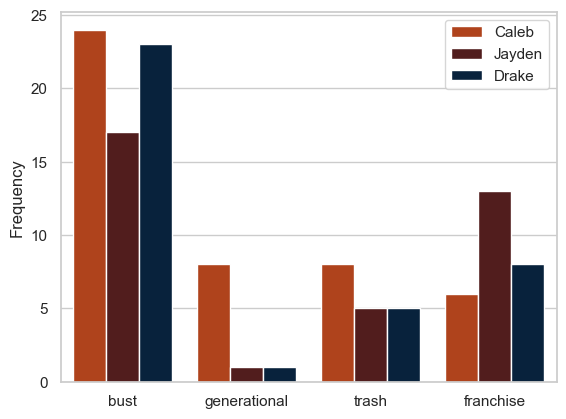

In [235]:
# occurrence of notable words by quarterback
words = ['bust', 'generational', 'trash', 'franchise']

plot_data = pd.melt(bag_df.loc[words, ['caleb', 'jayden', 'drake']].T.reset_index(names='qb'), id_vars=['qb'], value_vars=words, value_name='count', var_name='word')


ax = sns.barplot(
    data = plot_data, 
    x = 'word',
    hue = 'qb',
    y = 'count',
    palette = ['#C83803', '#5A1414', '#002244'], 
)
ax.set_xlabel('')
ax.set_ylabel('Frequency')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[label.capitalize() for label in labels]);

In [75]:
# getting sentiment scores for individual words
bag_df['sentiment'] = bag_df.index
bag_df['sentiment'] = bag_df['sentiment'].apply(get_sentiment)

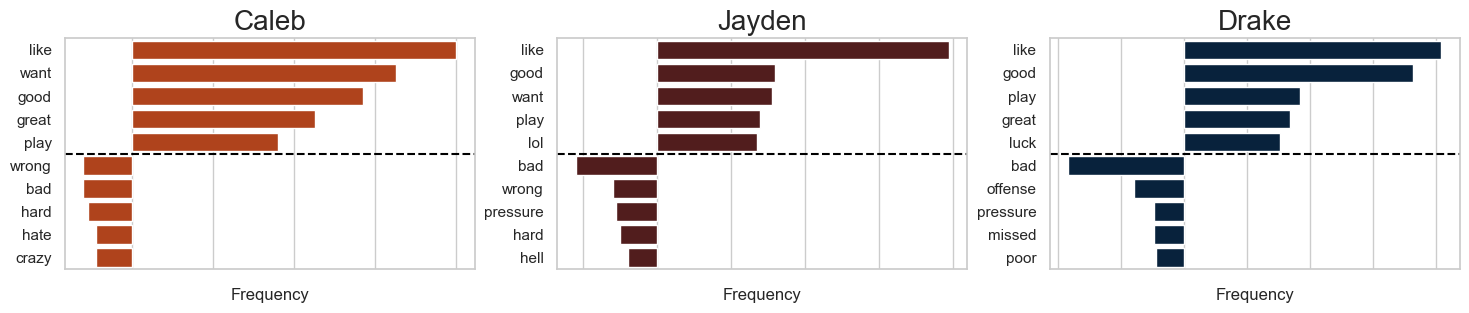

In [196]:
# 5 most common positive words and 5 most common negative words for each quarterback
# positive or negative defined as not equal to zero
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))

for i, qb in enumerate(bag_df.columns[:3]):
    # get list of top ten most common words for each qb
    top_5 = bag_df[qb].loc[bag_df['sentiment'] > 0].sort_values(ascending=False).head(5).reset_index().rename(columns={'index': 'word', qb: 'count'})
    bot_5 = bag_df[qb].loc[bag_df['sentiment'] < 0].sort_values(ascending=False).head(5).reset_index().rename(columns={'index': 'word', qb: 'count'})

    bot_5['count'] *= -1
    dat = pd.concat([top_5, bot_5])

    # plot barplot of top ten words
    sns.barplot(
        data = dat,
        x = 'count',
        y = 'word',
        color = qb_colors[qb], # team colors
        ax = axes[i]
    )
    axes[i].set_title(qb.capitalize(), fontsize=20)
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('')
    axes[i].set_xticklabels([])
    axes[i].axhline(4.51, color='black', ls='--')

    


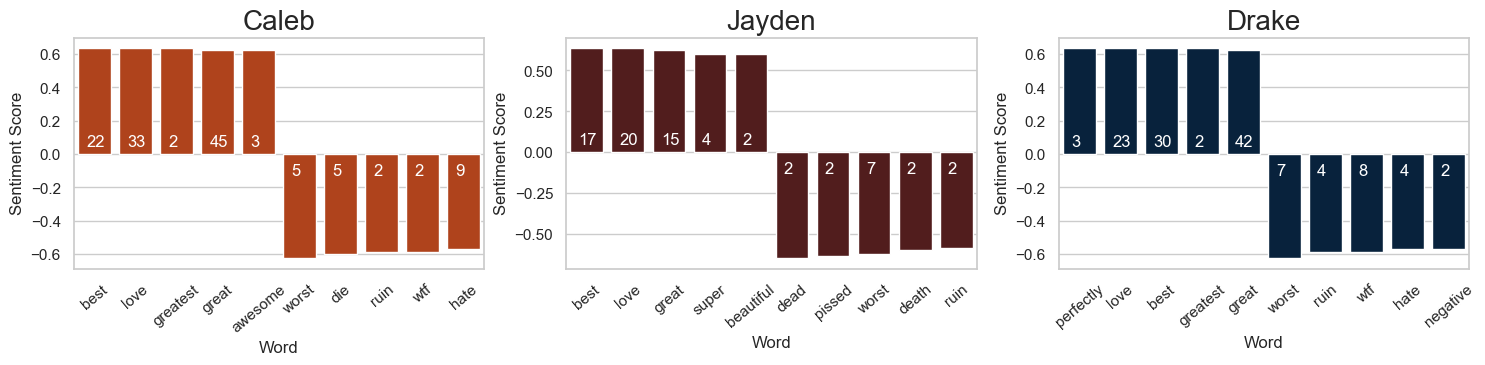

In [213]:
# the strongest sentiment words used for each quarterback, occurring at least min_times times
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))

min_times = 2

for i, qb in enumerate(bag_df.columns[:3]):
    # remove nfc, which has an oddly low polarity score
    bag_df_clean = bag_df.loc[(bag_df.index != 'nfc') & (bag_df.index != 'hell')]


    # get list of highest polarity words for each qb

    top_5 = bag_df_clean.loc[bag_df[qb] >= min_times].sort_values('sentiment', ascending=False).head(5).reset_index().rename(columns={'index': 'word', qb: 'count'})
    bot_5 = bag_df_clean.loc[bag_df[qb] >= min_times].sort_values('sentiment', ascending=True).head(5).reset_index().rename(columns={'index': 'word', qb: 'count'})

    dat = pd.concat([top_5, bot_5]).reset_index()
    # plot barplot of top ten words
    sns.barplot(
        data = dat,
        x = 'word',
        y = 'sentiment',
        color = qb_colors[qb], # team colors
        ax = axes[i]
    )
    axes[i].set_title(qb.capitalize(), fontsize=20)
    axes[i].set_xlabel('Word')
    axes[i].set_ylabel('Sentiment Score')

    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=40) # rotate xticks

    for n, x in enumerate(range(10)):
        axes[i].text(x=x-.2, y=.05 if n < 5 else -.13, s = round(dat.loc[n, 'count']), color='white')
